# Models training
In this notebook we train and analyze multiple models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

with open('landmarks_subset_proccessed.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)

data_info = pd.read_csv('video_labels.csv',dtype={'video_id': object})
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'cold', 'pizza', 'top', 'cheese', 'taste',
                'delicious', 'lazy', 'afternoon', 'dark', 'room', 'small', 'lamp', 'empty',
                'big', 'dog', 'walk', 'beautiful', 'every', 'morning', 'short',
                'woman', 'wear', 'dress', 'have', 'beautiful', 'daughter']


POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
videos_per_word = Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

# 1.0 Unsupervised
We first try and distinguish the words without letting the model know the labels.

# 1.1 Dynamic Time Wrapping and KMeans (DTW)
Dynamic Time Wrapping can detect similar motions but its computation is slow, let's take videos of two words only, without the face (which has the majority of landmarks) and check whether it is a good approach.

We start with a sainity check for DTW. Just a few sample to keep computations reasonably quick.

In [34]:
words = ["play","basketball","morning","tall","dress","beautiful"]
words = ["short", "tall", "woman", "man","small", "big", "morning", "afternoon", ]
for word in words:
    print(word, videos_per_word[word])

dtw_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    for vid in videos[:2]:
        dtw_landmarks[vid] = subset_landmarks[vid][::3,POSE+LH+RH,:] # Exclude augmented videos for now
len(dtw_landmarks)

short 13
tall 13
woman 11
man 12
small 8
big 9
morning 6
afternoon 7


16

/Users/oren/anaconda3/envs/ai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


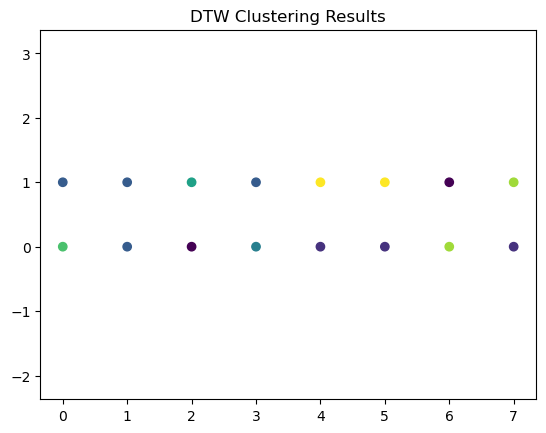

['short', 'tall', 'woman', 'man', 'small', 'big', 'morning', 'afternoon']


In [35]:
# Me: write me a python code to cluster mediapipe video landmarks using DTW
# ChatGPT 3.5 answers:

# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform clustering using DTW
def dtw_cluster(video_landmarks, num_clusters):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    # Perform KMeans clustering based on DTW distances
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(distances)

    return labels

# Example usage
# Assuming 'video_landmarks' is a list of 2D arrays representing landmarks for each frame
# You can adjust 'num_clusters' based on your requirements
num_clusters = len(words)
cluster_labels = dtw_cluster(dtw_landmarks.values(), num_clusters)

# Visualize the clustering results
x = np.array([i for i in range(len(dtw_landmarks))])%int(len(dtw_landmarks)/2)
y = [0] * int(len(dtw_landmarks)/2) + [1] * int(len(dtw_landmarks)/2)

#plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.title('DTW Clustering Results')
plt.axis('equal')

plt.show()
print(words)

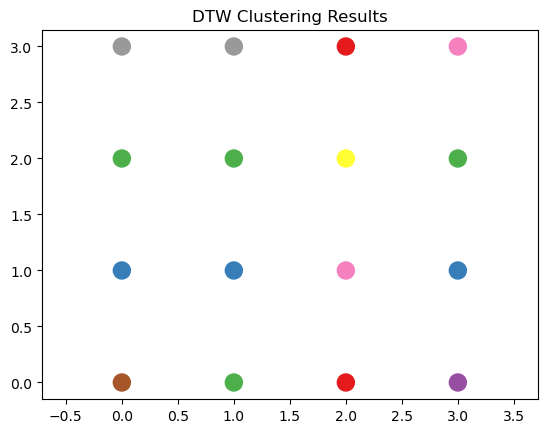

In [49]:
# Visualize the clustering results
x = np.array([i for i in range(len(dtw_landmarks))])%int(len(dtw_landmarks)/4)
y = [0] * int(len(dtw_landmarks)/4) + [1] * int(len(dtw_landmarks)/4) +[2] * int(len(dtw_landmarks)/4) + [3] * int(len(dtw_landmarks)/4)

#plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.scatter(x, y, c=cluster_labels, cmap='Set1', marker='o', s=150, alpha=1)
plt.title('DTW Clustering Results')
plt.axis('equal')
plt.show()

## 3.2 LSTM
Copy from a tutorial

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [61]:
subset_landmarks['51221'].shape[1]

543

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()